In [1]:
#Required Packages

import dlib
import cv2
from imutils import face_utils
from scipy.spatial import distance 
import math
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

p = "Advanced_Drowsiness_Detection-main/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

In [2]:
def live():
    cap = cv2.VideoCapture(0)
    data = []
    result = []
    while True:
        # Getting out image by webcam 
        _, image = cap.read()
        # Converting the image to gray scale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Get faces into webcam's image
        rects = detector(image, 0)

        # For each detected face, find the landmark.
        for (i, rect) in enumerate(rects):
            # Make the prediction and transfom it to numpy array
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            Result_String, features = model(shape)
            cv2.putText(image,Result_String, bottomLeftCornerOfText, font, fontScale, fontColor,lineType)
            data.append (features)
            result.append(Result_String)

            # Draw on our image, all the finded cordinate points (x,y) 
            for (x, y) in shape:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

        # Show the image
        cv2.imshow("Output", image)

        k = cv2.waitKey(300) & 0xFF
        if k == 27:
            break

    cv2.destroyAllWindows()
    cap.release()
    
    return data,result

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,400)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

In [3]:
#Feature Functions

def eye_aspect_ratio(eye):
	A = distance.euclidean(eye[1], eye[5])
	B = distance.euclidean(eye[2], eye[4])
	C = distance.euclidean(eye[0], eye[3])
	ear = (A + B) / (2.0 * C)
	return ear

def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[14], mouth[18])
    C = distance.euclidean(mouth[12], mouth[16])
    mar = (A ) / (C)
    return mar

def circularity(eye):
    A = distance.euclidean(eye[1], eye[4])
    radius  = A/2.0
    Area = math.pi * (radius ** 2)
    p = 0
    p += distance.euclidean(eye[0], eye[1])
    p += distance.euclidean(eye[1], eye[2])
    p += distance.euclidean(eye[2], eye[3])
    p += distance.euclidean(eye[3], eye[4])
    p += distance.euclidean(eye[4], eye[5])
    p += distance.euclidean(eye[5], eye[0])
    return 4 * math.pi * Area /(p**2)

def mouth_over_eye(eye):
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    mouth_eye = mar/ear
    return mouth_eye


def average(y_pred):
    """Averaging sequential frames for classifier"""
    for i in range(1, len(y_pred)-1):
        if i % 240 == 0 or (i+1) % 240 == 0:
            pass
        else: 
            average = float(y_pred[i-1] + y_pred[i] + y_pred[i+1])/3
            if average >= 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
    return y_pred

In [4]:
#Read in the Data file to Train Model
df = pd.read_csv('Advanced_Drowsiness_Detection-main/data_drowsiness/prepared/totalwithmaininfo.csv',sep=',')
print(df.info)
#df = df.drop(df.columns[0],axis=1)
participants = set(df.Participant)
df = df.drop(["Participant"], axis=1)
df = df[df.Y != 5.0]  
df.loc[df.Y == 0.0, "Y"] = int(0)
df.loc[df.Y == 10.0, "Y"] = int(1)
train_percentage = 17/22
train_index = int(len(df)*train_percentage)
test_index = len(df)-train_index

df_train = df[:train_index]
df_test = df[-test_index:]

df_train

<bound method DataFrame.info of           Y       MOE  Participant       EAR       MAR  Circularity  \
0       0.0  2.534145          1.0  0.312688  0.792397     0.432896   
1       0.0  2.379947          1.0  0.321940  0.766199     0.486923   
2       0.0  2.078550          1.0  0.331216  0.688449     0.456029   
3       0.0  2.509767          1.0  0.309246  0.776136     0.452655   
4       0.0  3.586821          1.0  0.204691  0.734189     0.361123   
...     ...       ...          ...       ...       ...          ...   
17310  10.0  5.349703         63.0  0.181047  0.968549     0.314714   
17311  10.0  5.530147         63.0  0.178874  0.989198     0.306021   
17312  10.0  5.536179         63.0  0.180700  1.000386     0.315374   
17313  10.0  5.472988         63.0  0.181437  0.993005     0.321619   
17314  10.0  6.011408         63.0  0.171145  1.028824     0.299138   

           EAR_N     MAR_N  Circularity_N     MOE_N  
0      -0.999551  0.802437      -0.948848  0.877172  
1      

,Y,MOE,EAR,MAR,Circularity,EAR_N,MAR_N,Circularity_N,MOE_N
0,0.0,2.534145,0.312688,0.792397,0.432896,-0.999551,0.802437,-0.948848,0.877172
1,0.0,2.379947,0.321940,0.766199,0.486923,-0.000897,0.317858,1.044306,0.211742
2,0.0,2.078550,0.331216,0.688449,0.456029,1.000448,-1.120295,-0.095458,-1.088914
3,0.0,2.509767,0.309246,0.776136,0.452655,-1.371052,0.501666,-0.219920,0.771970
4,0.0,3.586821,0.204691,0.734189,0.361123,-12.657205,-0.274242,-3.596686,5.419921
...,...,...,...,...,...,...,...,...,...
14302,0.0,4.763455,0.207216,0.987066,0.363308,1.455722,1.145374,1.665879,-0.967338
14303,0.0,6.422775,0.145763,0.936200,0.299323,0.133184,-0.138293,-0.336766,-0.399989
14304,0.0,6.674098,0.142154,0.948752,0.310985,0.055531,0.178463,0.028256,-0.314057
14305,0.0,6.509831,0.142154,0.925400,0.294415,0.055531,-0.410839,-0.490363,-0.370223


In [5]:
X_test = df_test.drop(['Y'],axis = 1)
y_test = df_test["Y"]

X_train = df_train.drop(['Y'],axis=1)
y_train = df_train['Y']

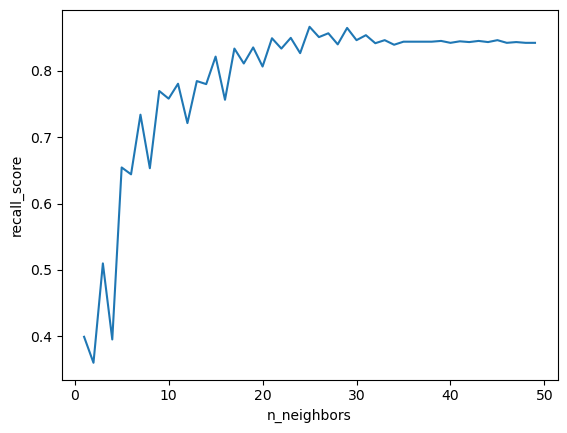

36
25


In [6]:
#KNN
X = []
acc3_list = []
f1_score3_list = []
roc_3_list = []
from sklearn.neighbors import KNeighborsClassifier
for i in range(1,50):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train) 
    pred_KN = neigh.predict(X_test)
    #pKN = np.mean(pred_KN)
    #print(pred_KN.shape)
    #pred_KN2 = np.array([pKN for i in pred_KN])
    #print(pred_KN2)
    pred_KN = average(pred_KN)
    # print(pred_KN)
    X.append(i)
    y_score_3 = neigh.predict_proba(X_test)[:,1]
    acc3_list.append(accuracy_score(y_test, pred_KN))
    f1_score3_list.append(metrics.recall_score(y_test, pred_KN))
    roc_3_list.append(metrics.roc_auc_score(y_test, y_score_3))
    
plt.plot(X, f1_score3_list)
plt.xlabel("n_neighbors")
plt.ylabel("recall_score")
plt.show()
print(acc3_list.index(max(acc3_list))+1)
print(f1_score3_list.index(max(f1_score3_list))+1)
# neigh = KNeighborsClassifier(n_neighbors=acc3_list.index(max(acc3_list))+1)
# # neigh = KNeighborsClassifier(n_neighbors=3)
# neigh.fit(X_train, y_train) 
# pred_KN = neigh.predict(X_test)
# pred_KN = average(pred_KN)
# y_score_3 = neigh.predict_proba(X_test)[:,1]
# acc3 = accuracy_score(y_test, pred_KN)
# f1_score_3 = metrics.f1_score(y_test, pred_KN, average = None)
# roc_3 = metrics.roc_auc_score(y_test, y_score_3)
# print([acc3,f1_score_3,roc_3])
# print(confusion_matrix(y_test, pred_KN))

In [22]:
def model(landmarks):

    features = pd.DataFrame(columns=["EAR","MAR","Circularity","MOE"])

    eye = landmarks[36:68]
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    cir = circularity(eye)
    mouth_eye = mouth_over_eye(eye)

    df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)

    df["EAR_N"] = (df["EAR"]-mean["EAR"])/ std["EAR"]
    df["MAR_N"] = (df["MAR"]-mean["MAR"])/ std["MAR"]
    df["Circularity_N"] = (df["Circularity"]-mean["Circularity"])/ std["Circularity"]
    df["MOE_N"] = (df["MOE"]-mean["MOE"])/ std["MOE"]
    
    Result = neigh.predict(df)
    

    return Result, df.values

In [23]:
def calibration():
    data = []
    cap = cv2.VideoCapture(0)
    cnt = 0
    while True:
        # Getting out image by webcam 
        cnt += 1
        _, image = cap.read()
        # Converting the image to gray scale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Get faces into webcam's image
        rects = detector(image, 0) #assume rects.len = 1

        # For each detected face, find the landmark.
        for (i, rect) in enumerate(rects):
            # Make the prediction and transfom it to numpy array
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            data.append(shape)
            cv2.putText(image,"Calibrating...", bottomLeftCornerOfText, font, fontScale, fontColor,lineType)

            # Draw on our image, all the finded cordinate points (x,y) 
            for (x, y) in shape:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

        # Show the image
        cv2.imshow("Output", image)

        k = cv2.waitKey(5) & 0xFF
        if k == 27 or cnt == 100:
            break
    
    cv2.destroyAllWindows()
    cap.release()
    
    
    features_test = []
    for d in data:
        eye = d[36:68]
        ear = eye_aspect_ratio(eye)
        mar = mouth_aspect_ratio(eye)
        cir = circularity(eye)
        mouth_eye = mouth_over_eye(eye)
        features_test.append([ear, mar, cir, mouth_eye])
    
    features_test = np.array(features_test)
    x = features_test
    y = pd.DataFrame(x,columns=["EAR","MAR","Circularity","MOE"])
    df_means = y.mean(axis=0)
    df_std = y.std(axis=0)
    
    return df_means,df_std

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,400)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

In [24]:
def live():
    cap = cv2.VideoCapture(0)
    data = []
    result = []
    res_list = []
    while True:
        # Getting out image by webcam 
        _, image = cap.read()
        # Converting the image to gray scale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Get faces into webcam's image
        rects = detector(image, 0)
        # For each detected face, find the landmark.
        for (i, rect) in enumerate(rects):
            # Make the prediction and transfom it to numpy array
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            Result, features = model(shape)
            if Result == 1:
                Result_String1 = "Drowsy"
            else:
                Result_String1 = "Alert"
            # cv2.putText(image,Result_String, (9, 400), font, fontScale, fontColor,lineType)
            res_list.append(int(Result))
            if(len(res_list) > 10):
                res_list.pop(0)
            Result = sum(res_list) / len(res_list)
            if Result > 0.4:
                Result_String = "Drowsy"
            else:
                Result_String = "Alert"
            cv2.putText(image,Result_String+ " " + Result_String1, bottomLeftCornerOfText, font, fontScale, fontColor,lineType)
            data.append (features)
            result.append(Result_String1)
            # Draw on our image, all the finded cordinate points (x,y) 
            for (x, y) in shape:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

        # Show the image
        cv2.imshow("Output", image)

        k = cv2.waitKey(300) & 0xFF
        if k == 27:
            break

    cv2.destroyAllWindows()
    cap.release()
    
    return data,result

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,400)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

In [25]:
#Run Calibration
mean, std = calibration()

In [26]:
#Run Demonstration
features, result = live()

C:\Users\Admin\AppData\Local\Temp\ipykernel_18956\2581864107.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
c:\Users\Admin\anaconda3\envs\AIP\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\Admin\AppData\Local\Temp\ipykernel_18956\2581864107.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)
c:\Users\Admin\anaconda3\envs\AIP\lib\site-packages\sklearn\base.py:493: FutureWarning: The f

Text(0.5, 0, 'Time (Frames Captured)')

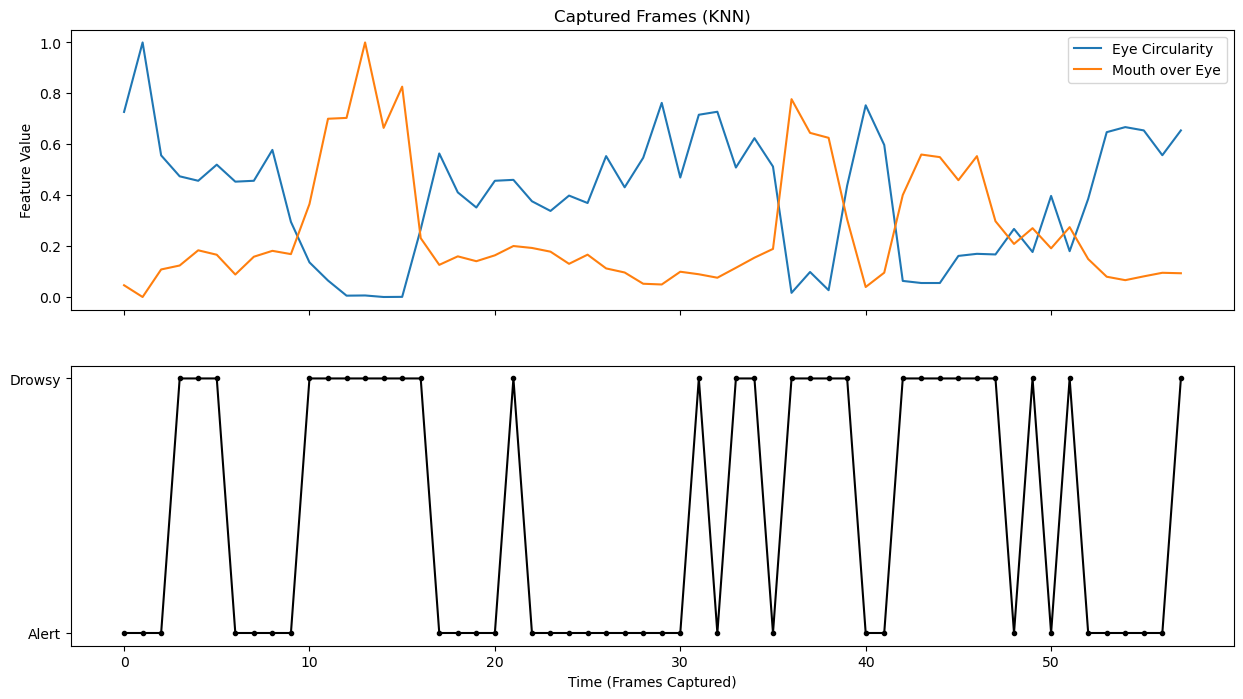

In [27]:
# Plot Results
features =np.vstack(features)
y = pd.DataFrame(features, columns=["EAR","MAR","Circularity","MOE","EAR_N","MAR_N","Circularity_N","MOE_N"])
y = y.drop(columns=["EAR_N","MAR_N","Circularity_N","MOE_N"])

x = y.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
y = pd.DataFrame(x_scaled, columns=["Eye Aspect Ratio","Mouth Aspect Ratio","Eye Circularity","Mouth over Eye"])

y["Result"] = result

fig, (ax1, ax2) = plt.subplots(nrows=2,
                               ncols=1,
                               sharex=True,
                               sharey=False,
                               figsize=(15, 8))

ax1.set_title("Captured Frames (KNN)")
ax1.plot(y["Eye Circularity"])
ax1.plot(y["Mouth over Eye"])
ax1.legend(("Eye Circularity", "Mouth over Eye"), loc="best")
ax1.set_ylabel('Feature Value')

ax2.plot(y["Result"],marker = '.', color = "Black")
ax2.set_xlabel('Time (Frames Captured)')